# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda

Vamos trabalhar com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [217]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [218]:
df = pd.read_csv('previsao_de_renda.csv', parse_dates=['data_ref'])
df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               15000 non-null  datetime64[ns]
 1   id_cliente             15000 non-null  int64         
 2   sexo                   15000 non-null  object        
 3   posse_de_veiculo       15000 non-null  bool          
 4   posse_de_imovel        15000 non-null  bool          
 5   qtd_filhos             15000 non-null  int64         
 6   tipo_renda             15000 non-null  object        
 7   educacao               15000 non-null  object        
 8   estado_civil           15000 non-null  object        
 9   tipo_residencia        15000 non-null  object        
 10  idade                  15000 non-null  int64         
 11  tempo_emprego          12427 non-null  float64       
 12  qt_pessoas_residencia  15000 non-null  float64       
 13  r

1. Ajuste um modelo para prever log(renda) considerando todas as covariáveis disponíveis.
    - Utilizando os recursos do Patsy, coloque as variáveis qualitativas como *dummies*.
    - Mantenha sempre a categoria mais frequente como casela de referência
    - Avalie os parâmetros e veja se parecem fazer sentido prático.

2. Remova a variável menos significante e analise:
    - Observe os indicadores que vimos, e avalie se o modelo melhorou ou piorou na sua opinião.
    - Observe os parâmetros e veja se algum se alterou muito.

3. Siga removendo as variáveis menos significantes, sempre que o *p-value* for menor que 5%. Compare o modelo final com o inicial. Observe os indicadores e conclua se o modelo parece melhor. 
    

In [220]:
var_qualitativa = df.select_dtypes(include=['object','bool'])
var_qualitativa.head()

,sexo,posse_de_veiculo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia
0,F,False,True,Empresário,Secundário,Solteiro,Casa
1,M,True,True,Assalariado,Superior completo,Casado,Casa
2,F,True,True,Empresário,Superior completo,Casado,Casa
3,F,False,True,Servidor público,Superior completo,Casado,Casa
4,M,True,False,Assalariado,Secundário,Solteiro,Governamental


In [221]:
var_qualitativa['sexo'].value_counts()

F    10119
M     4881
Name: sexo, dtype: int64

In [222]:
var_qualitativa['posse_de_veiculo'].value_counts()

False    9140
True     5860
Name: posse_de_veiculo, dtype: int64

In [223]:
var_qualitativa['posse_de_imovel'].value_counts()

True     10143
False     4857
Name: posse_de_imovel, dtype: int64

In [224]:
var_qualitativa['tipo_renda'].value_counts()

Assalariado         7633
Empresário          3508
Pensionista         2582
Servidor público    1268
Bolsista               9
Name: tipo_renda, dtype: int64

In [225]:
var_qualitativa['educacao'].value_counts()

Secundário             8895
Superior completo      5335
Superior incompleto     579
Primário                165
Pós graduação            26
Name: educacao, dtype: int64

In [226]:
var_qualitativa['estado_civil'].value_counts()

Casado      10534
Solteiro     1798
União        1078
Separado      879
Viúvo         711
Name: estado_civil, dtype: int64

In [227]:
var_qualitativa['tipo_residencia'].value_counts()

Casa             13532
Com os pais        675
Governamental      452
Aluguel            194
Estúdio             83
Comunitário         64
Name: tipo_residencia, dtype: int64

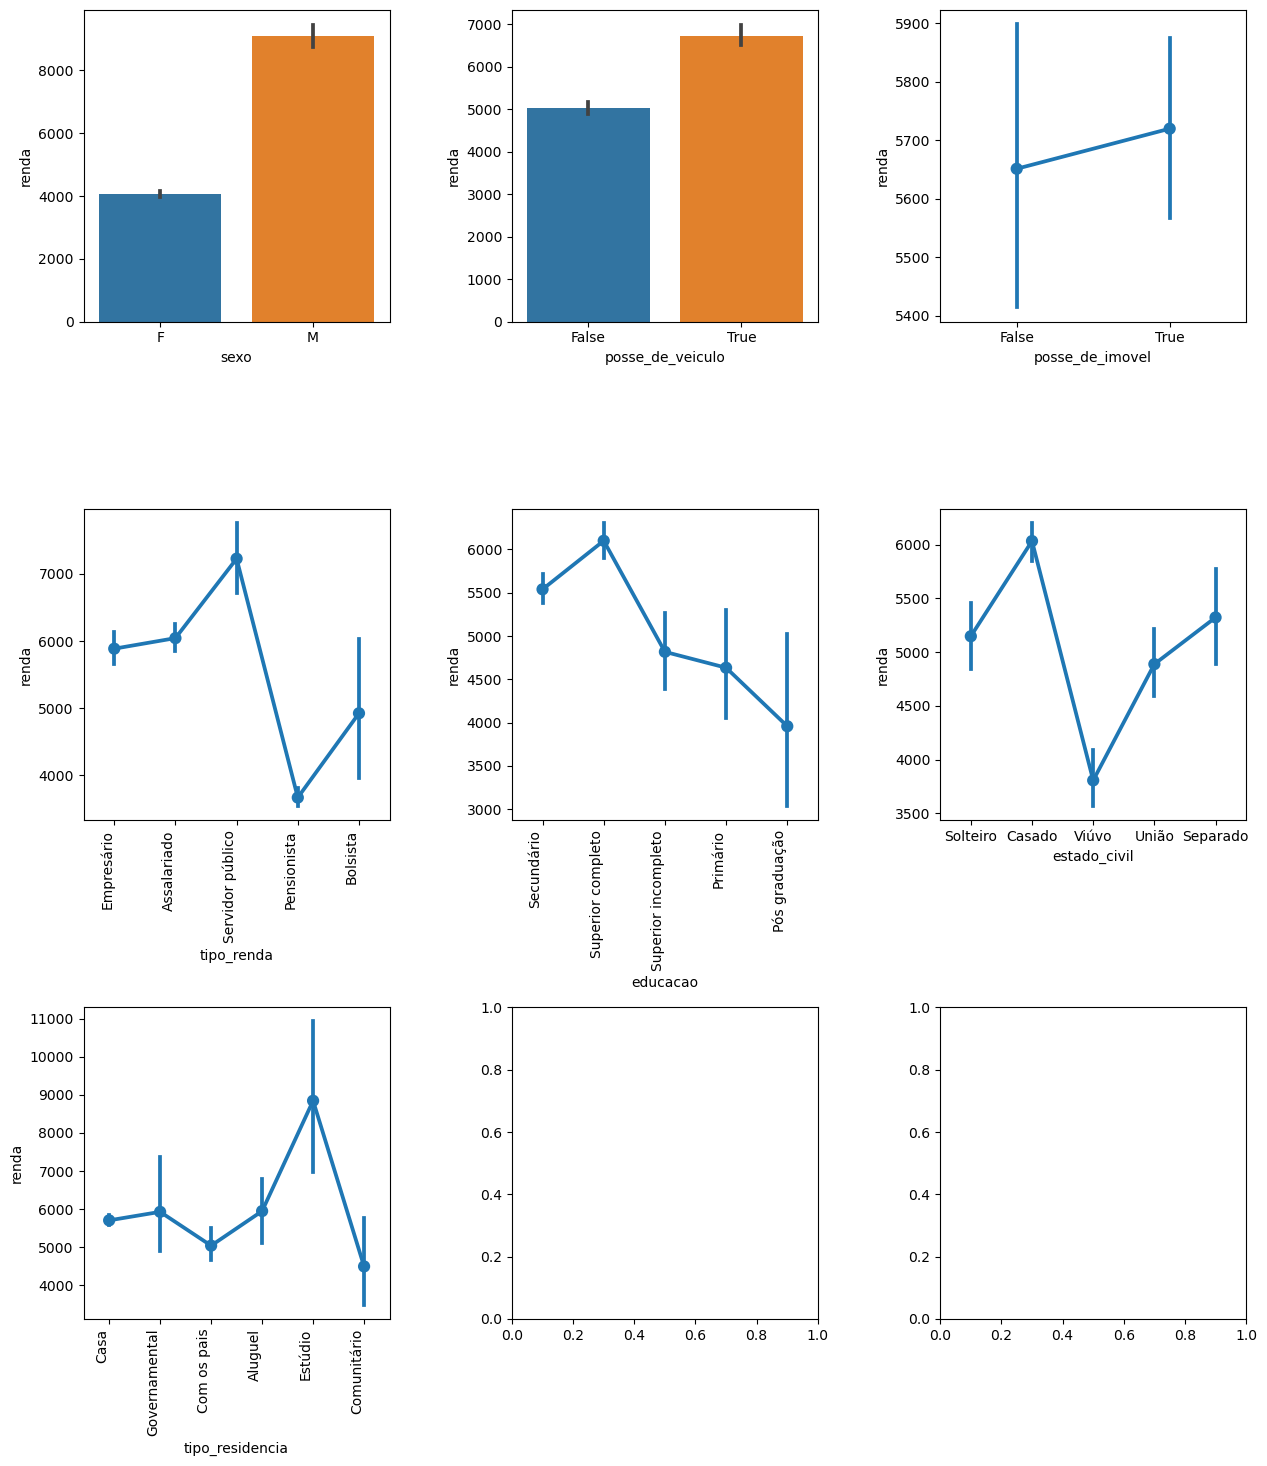

In [228]:
plt.close('all')

plt.rc('figure', figsize=(15, 17))
fig, axes = plt.subplots(3, 3)

sns.barplot(ax = axes[0, 0],y = 'renda', x = 'sexo', data = df)
sns.barplot(ax = axes[0, 1],y = 'renda', x = 'posse_de_veiculo', data = df)
sns.pointplot(ax = axes[0, 2],y = 'renda', x = 'posse_de_imovel', data = df)
tipo_renda = sns.pointplot(ax = axes[1, 0],y = 'renda', x = 'tipo_renda', data = df)
educação = sns.pointplot(ax = axes[1, 1],y = 'renda', x = 'educacao', data = df)
sns.pointplot(ax = axes[1, 2],y = 'renda', x = 'estado_civil', data = df)
tipo_residencia = sns.pointplot(ax = axes[2, 0],y = 'renda', x = 'tipo_residencia', data = df)

tipo_renda.set_xticklabels(tipo_renda.get_xticklabels(), rotation=90, horizontalalignment='right')
educação.set_xticklabels(educação.get_xticklabels(), rotation=90, horizontalalignment='right')
tipo_residencia.set_xticklabels(tipo_residencia.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

In [229]:
y, x = patsy.dmatrices('''np.log(renda) ~ C(sexo, Treatment(0))
                               + C(posse_de_veiculo, Treatment(0))  
                               + C(posse_de_imovel, Treatment(0))
                               + C(tipo_renda, Treatment(1))
                               + C(educacao, Treatment(1))
                               + C(estado_civil, Treatment(1))
                               + C(tipo_residencia, Treatment(1))                                                           
                               + qtd_filhos
                               + idade
                               + tempo_emprego
                               + qt_pessoas_residencia
                       ''', data = df)
x

DesignMatrix with shape (12427, 25)
  Columns:
    ['Intercept',
     'C(sexo, Treatment(0))[T.M]',
     'C(posse_de_veiculo, Treatment(0))[T.True]',
     'C(posse_de_imovel, Treatment(0))[T.True]',
     'C(tipo_renda, Treatment(1))[T.Assalariado]',
     'C(tipo_renda, Treatment(1))[T.Empresário]',
     'C(tipo_renda, Treatment(1))[T.Pensionista]',
     'C(tipo_renda, Treatment(1))[T.Servidor público]',
     'C(educacao, Treatment(1))[T.Primário]',
     'C(educacao, Treatment(1))[T.Secundário]',
     'C(educacao, Treatment(1))[T.Superior completo]',
     'C(educacao, Treatment(1))[T.Superior incompleto]',
     'C(estado_civil, Treatment(1))[T.Casado]',
     'C(estado_civil, Treatment(1))[T.Solteiro]',
     'C(estado_civil, Treatment(1))[T.União]',
     'C(estado_civil, Treatment(1))[T.Viúvo]',
     'C(tipo_residencia, Treatment(1))[T.Aluguel]',
     'C(tipo_residencia, Treatment(1))[T.Com os pais]',
     'C(tipo_residencia, Treatment(1))[T.Comunitário]',
     'C(tipo_residencia, Treatm

In [230]:
#coef = Estimativa Beta, 
#std err = erro padrao do Beta, 
#t = estatistica t-estimativa/erro padrao 
#P>|t| = P-value: probabilidade de observarmos um novo Beta chapeu sob H0, menos provavel que a estimativa atual
#[0.025	0.975] = Podemos dizer, com 95% de confianca, que o verdadeiro valor do parametro esta dentro desse intervalo

sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     287.5
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:08:39   Log-Likelihood:                -13568.
No. Observations:               12427   AIC:                         2.719e+04
Df Residuals:                   12402   BIC:                         2.737e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.1950      0.304     23.660      0.000       6.599       7.791
C(sexo, Treatment(0))[T.M]                            0.7874      0.015     53.723      0.000       0.759       0.816
C(posse_de_veiculo, Treatment(0))[T.True]             0.0441      0.014      3.119      0.002       0.016       0.072
C(posse_de_imovel, Treatment(0))[T.True]              0.0829      0.014      5.926      0.000       0.055       0.110
C(tipo_renda, Treatment(1))[T.Assalariado]           -0.2209      0.241     -0.916      0.360      -0.694       0.252
C(tipo_renda, Treatment(1))[T.Empresário]            -0.0657      0.241     -0.272      0.785      -0.539       0.407
C(tipo_renda, Treatment(1))[T.Pensionista]           -0.5296      0.341     -1.553      0.120      -1.198       0.139
C(tipo_renda, Treatment(1))[T.Servidor público]      -0.1633      0.242     -0.675      0.500      -0.637       0.311
C(educacao, Treatment(1))[T.Primário]                -0.1071      0.159     -0.673      0.501      -0.419       0.205
C(educacao, Treatment(1))[T.Secundário]              -0.1212      0.142     -0.853      0.394      -0.400       0.157
C(educacao, Treatment(1))[T.Superior completo]       -0.0133      0.142     -0.093      0.926      -0.292       0.265
C(educacao, Treatment(1))[T.Superior incompleto]     -0.1502      0.145     -1.035      0.301      -0.435       0.134
C(estado_civil, Treatment(1))[T.Casado]              -0.3265      0.111     -2.935      0.003      -0.545      -0.108
C(estado_civil, Treatment(1))[T.Solteiro]            -0.0593      0.033     -1.809      0.071      -0.124       0.005
C(estado_civil, Treatment(1))[T.União]               -0.3607      0.113     -3.182      0.001      -0.583      -0.138
C(estado_civil, Treatment(1))[T.Viúvo]                0.0424      0.048      0.875      0.382      -0.053       0.137
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0442      0.054      0.815      0.415      -0.062       0.150
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0184      0.029      0.625      0.532      -0.039       0.076
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.0754      0.091     -0.829      0.407      -0.254       0.103
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.1107      0.084      1.319      0.187      -0.054       0.275
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0129      0.039     -0.331      0.741      -0.089       0.064
qtd_filhos                                           -0.2658      0.108     -2.463      0.014      -0.477      -0.054
idade                                                 0.0053      0.001      6.624      0.000       0.004       0.007
tempo_emprego  

In [231]:
df2 = df.copy()

In [232]:
df2['tipo_renda'] = df2['tipo_renda'].apply(lambda i: i if i not in ['Empresário', 'Assalariado'] else 'Empresário/Assalariado')
df2['tipo_renda'].value_counts()

Empresário/Assalariado    11141
Pensionista                2582
Servidor público           1268
Bolsista                      9
Name: tipo_renda, dtype: int64

In [233]:
df2['estado_civil'] = df2['estado_civil'].apply(lambda i: i if i not in ['União', 'Casado'] else 'União/Casado')
df2['estado_civil'] = df2['estado_civil'].apply(lambda i: i if i not in ['Solteiro', 'Separado'] else 'Solteiro/Separado')
df2['estado_civil'].value_counts()

União/Casado         11612
Solteiro/Separado     2677
Viúvo                  711
Name: estado_civil, dtype: int64

In [234]:
df2['educacao'] = df2['educacao'].apply(lambda i: i if i not in  ['Superior incompleto', 'Primário'] else 'Superior incompleto/Primário')
df2['educacao'].value_counts()

Secundário                      8895
Superior completo               5335
Superior incompleto/Primário     744
Pós graduação                     26
Name: educacao, dtype: int64

In [235]:
df2['tipo_residencia'] = df2['tipo_residencia'].apply(lambda i: i if i not in  ['Governamental', 'Aluguel'] else 'Governamental/Aluguel')
df2['tipo_residencia'].value_counts()

Casa                     13532
Com os pais                675
Governamental/Aluguel      646
Estúdio                     83
Comunitário                 64
Name: tipo_residencia, dtype: int64

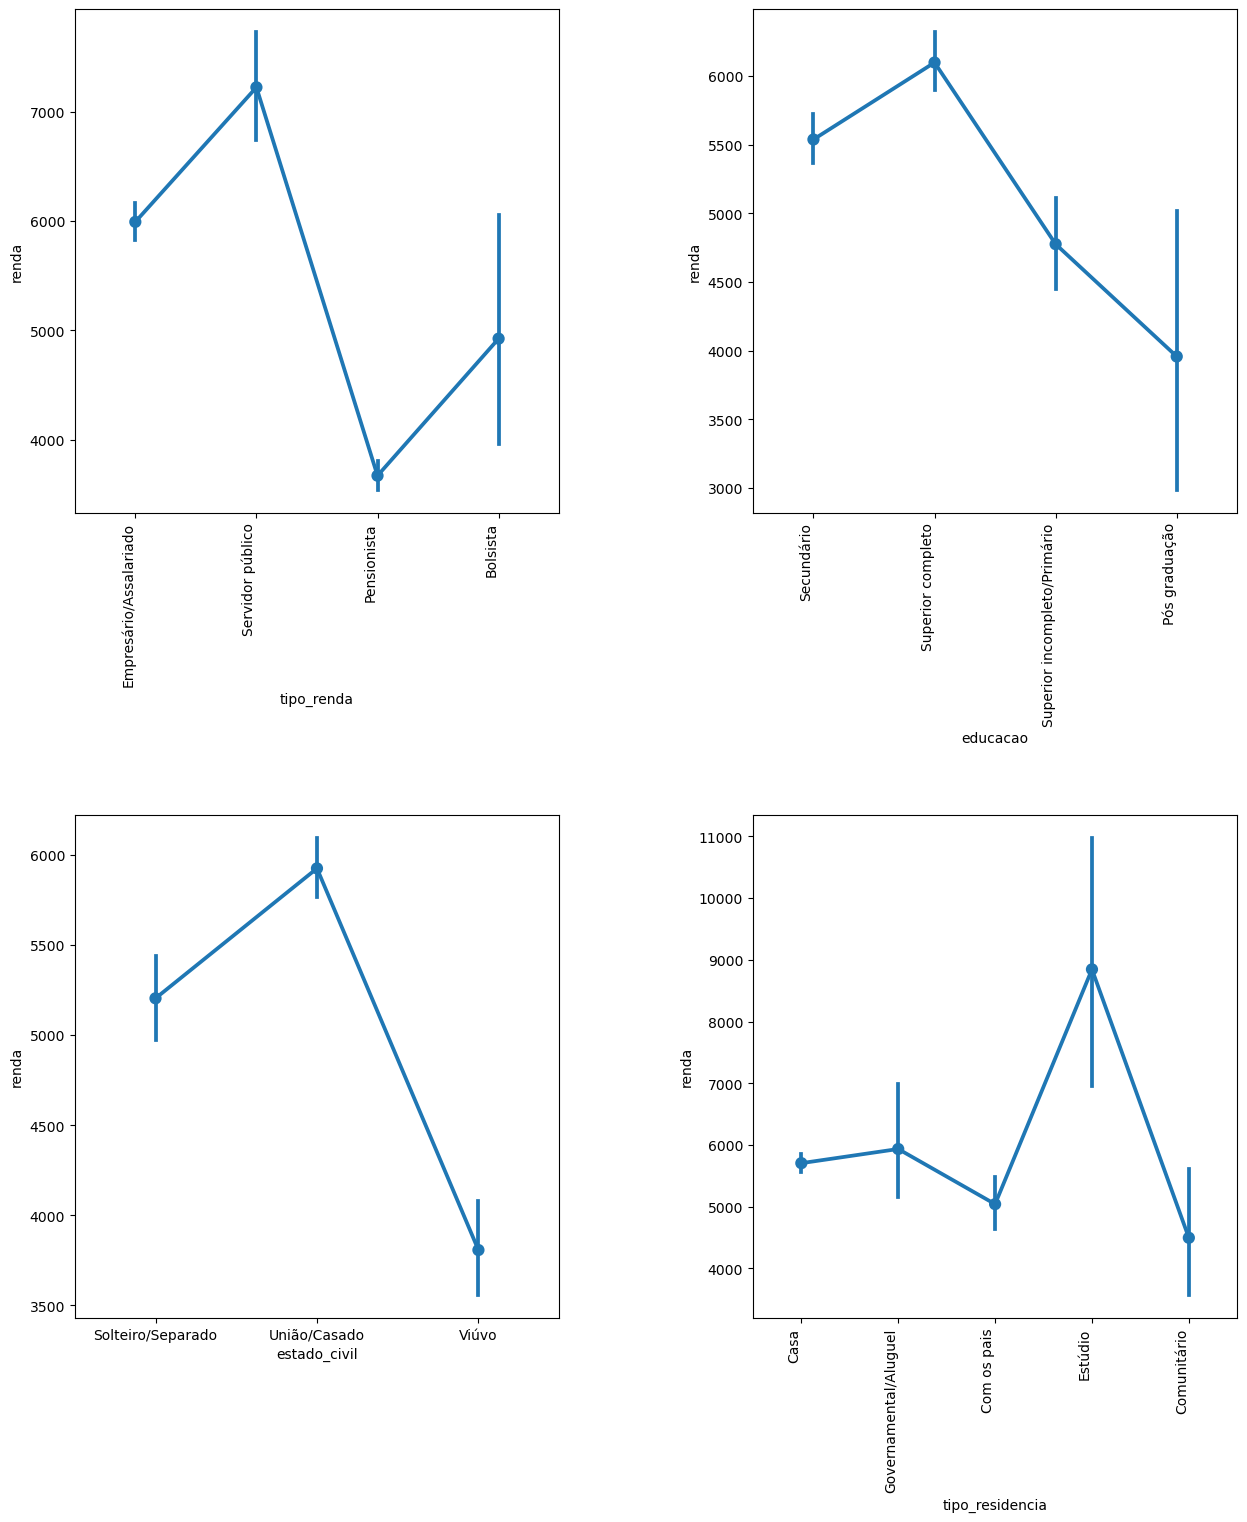

In [236]:
plt.close('all')

plt.rc('figure', figsize=(15, 17))
fig, axes = plt.subplots(2, 2)

tipo_renda = sns.pointplot(ax = axes[0, 0],y = 'renda', x = 'tipo_renda', data = df2)
educação = sns.pointplot(ax = axes[0, 1],y = 'renda', x = 'educacao', data = df2)
sns.pointplot(ax = axes[1, 0],y = 'renda', x = 'estado_civil', data = df2)
tipo_residencia = sns.pointplot(ax = axes[1, 1],y = 'renda', x = 'tipo_residencia', data = df2)

tipo_renda.set_xticklabels(tipo_renda.get_xticklabels(), rotation=90, horizontalalignment='right')
educação.set_xticklabels(educação.get_xticklabels(), rotation=90, horizontalalignment='right')
tipo_residencia.set_xticklabels(tipo_residencia.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

In [237]:
#coef = Estimativa Beta, 
#std err = erro padrao do Beta, 
#t = estatistica t-estimativa/erro padrao 
#P>|t| = P-value: probabilidade de observarmos um novo Beta chapeu sob H0, menos provavel que a estimativa atual
#[0.025	0.975] = Podemos dizer, com 95% de confianca, que o verdadeiro valor do parametro esta dentro desse intervalo

sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     287.5
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:12:04   Log-Likelihood:                -13568.
No. Observations:               12427   AIC:                         2.719e+04
Df Residuals:                   12402   BIC:                         2.737e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.1950      0.304     23.660      0.000       6.599       7.791
C(sexo, Treatment(0))[T.M]                            0.7874      0.015     53.723      0.000       0.759       0.816
C(posse_de_veiculo, Treatment(0))[T.True]             0.0441      0.014      3.119      0.002       0.016       0.072
C(posse_de_imovel, Treatment(0))[T.True]              0.0829      0.014      5.926      0.000       0.055       0.110
C(tipo_renda, Treatment(1))[T.Assalariado]           -0.2209      0.241     -0.916      0.360      -0.694       0.252
C(tipo_renda, Treatment(1))[T.Empresário]            -0.0657      0.241     -0.272      0.785      -0.539       0.407
C(tipo_renda, Treatment(1))[T.Pensionista]           -0.5296      0.341     -1.553      0.120      -1.198       0.139
C(tipo_renda, Treatment(1))[T.Servidor público]      -0.1633      0.242     -0.675      0.500      -0.637       0.311
C(educacao, Treatment(1))[T.Primário]                -0.1071      0.159     -0.673      0.501      -0.419       0.205
C(educacao, Treatment(1))[T.Secundário]              -0.1212      0.142     -0.853      0.394      -0.400       0.157
C(educacao, Treatment(1))[T.Superior completo]       -0.0133      0.142     -0.093      0.926      -0.292       0.265
C(educacao, Treatment(1))[T.Superior incompleto]     -0.1502      0.145     -1.035      0.301      -0.435       0.134
C(estado_civil, Treatment(1))[T.Casado]              -0.3265      0.111     -2.935      0.003      -0.545      -0.108
C(estado_civil, Treatment(1))[T.Solteiro]            -0.0593      0.033     -1.809      0.071      -0.124       0.005
C(estado_civil, Treatment(1))[T.União]               -0.3607      0.113     -3.182      0.001      -0.583      -0.138
C(estado_civil, Treatment(1))[T.Viúvo]                0.0424      0.048      0.875      0.382      -0.053       0.137
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0442      0.054      0.815      0.415      -0.062       0.150
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0184      0.029      0.625      0.532      -0.039       0.076
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.0754      0.091     -0.829      0.407      -0.254       0.103
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.1107      0.084      1.319      0.187      -0.054       0.275
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0129      0.039     -0.331      0.741      -0.089       0.064
qtd_filhos                                           -0.2658      0.108     -2.463      0.014      -0.477      -0.054
idade                                                 0.0053      0.001      6.624      0.000       0.004       0.007
tempo_emprego  

In [414]:
df2 = df.copy()

In [393]:
var_qualitativa = df.select_dtypes(include=['int64','float64'])
var_qualitativa.head()

,id_cliente,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
0,15056,0,26,6.602740,1.0,8060.34
1,9968,0,28,7.183562,2.0,1852.15
2,4312,0,35,0.838356,2.0,2253.89
3,10639,1,30,4.846575,3.0,6600.77
4,7064,0,33,4.293151,1.0,6475.97


In [377]:
var_qualitativa.drop('id_cliente', axis = 1, inplace=True)
var_qualitativa.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,26,6.602740,1.0,8060.34
1,0,28,7.183562,2.0,1852.15
2,0,35,0.838356,2.0,2253.89
3,1,30,4.846575,3.0,6600.77
4,0,33,4.293151,1.0,6475.97


In [378]:
var_qualitativa['qtd_filhos'].value_counts()

0     10376
1      3037
2      1376
3       185
4        17
7         5
14        2
5         2
Name: qtd_filhos, dtype: int64

In [379]:
idade = var_qualitativa['idade'].value_counts()
idade.head()

40    538
37    469
43    458
32    455
33    441
Name: idade, dtype: int64

In [380]:
tempo_emprego = var_qualitativa['tempo_emprego'].value_counts()
tempo_emprego.head()

4.216438     38
6.934247     30
7.520548     29
15.449315    27
5.717808     26
Name: tempo_emprego, dtype: int64

In [381]:
qt_pessoas_residencia = var_qualitativa['qt_pessoas_residencia'].value_counts()
qt_pessoas_residencia.head()

2.0    8181
1.0    2752
3.0    2551
4.0    1311
5.0     179
Name: qt_pessoas_residencia, dtype: int64

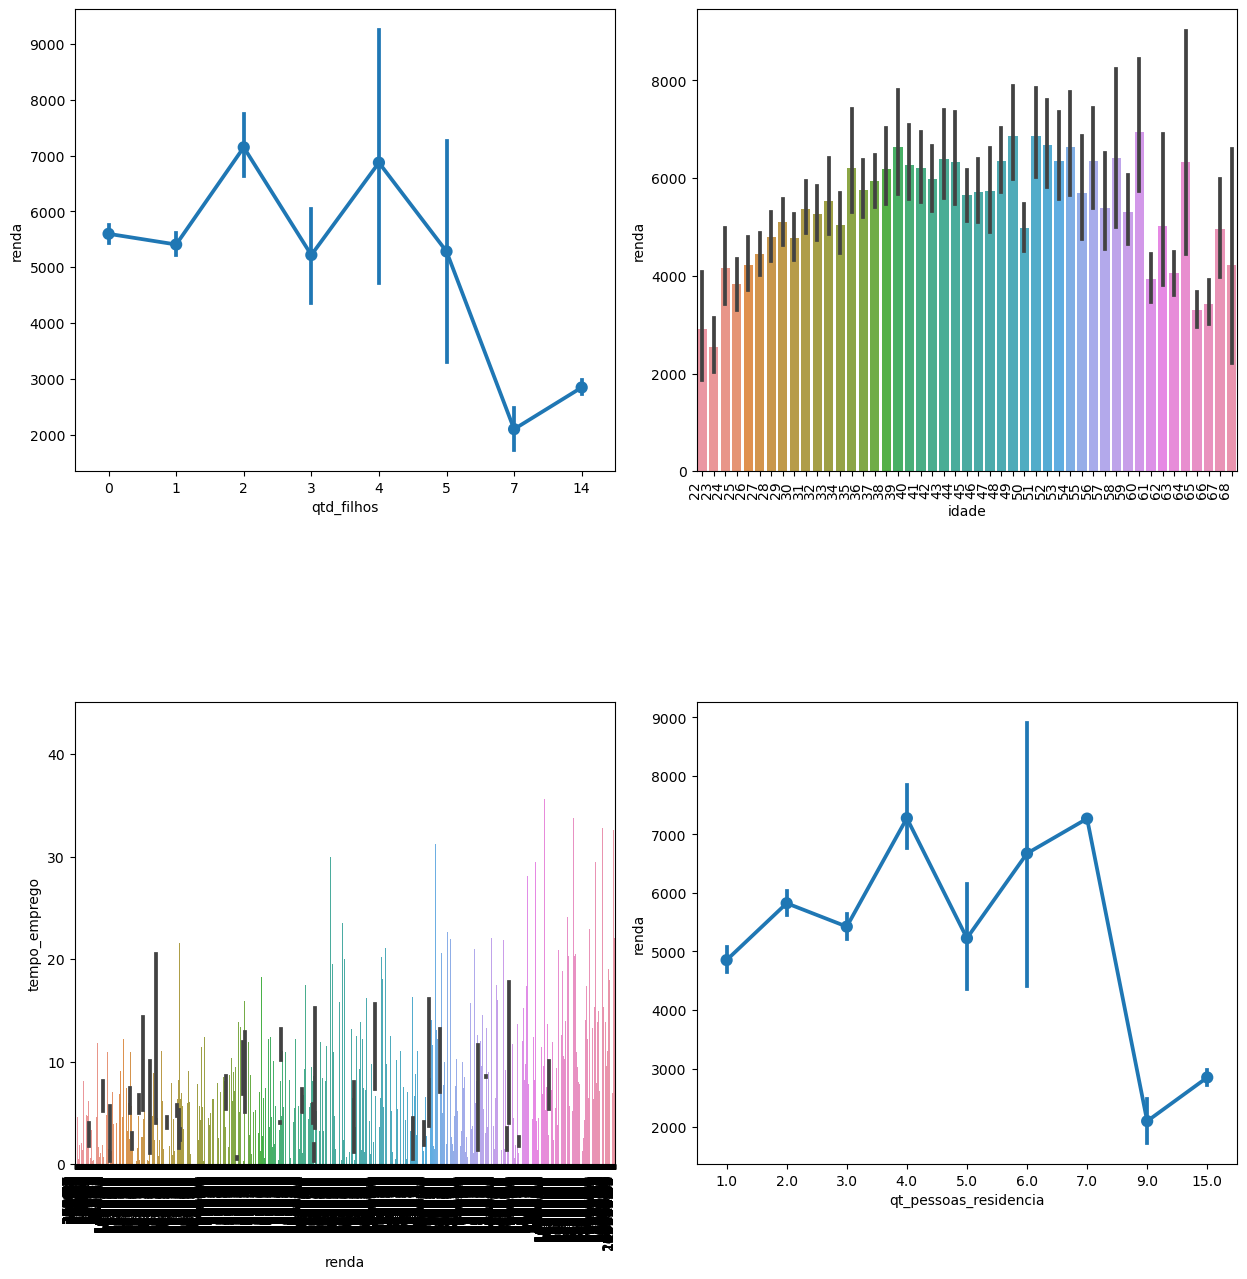

In [355]:
plt.close('all')

plt.rc('figure', figsize=(15, 15))
fig, axes = plt.subplots(2, 2)

sns.pointplot(ax = axes[0, 0],y = 'renda', x = 'qtd_filhos', data = df2)
idade = sns.barplot(ax = axes[0, 1],y = 'renda', x = 'idade', data = df2)
tempo_emprego = sns.barplot(ax = axes[1, 0],y='tempo_emprego', x='renda', data=df2)
sns.pointplot(ax = axes[1, 1],y = 'renda', x = 'qt_pessoas_residencia', data = df2)

idade.set_xticklabels(idade.get_xticklabels(), rotation=90, horizontalalignment='right')
tempo_emprego.set_xticklabels(tempo_emprego.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.subplots_adjust(wspace=0.15, hspace=0.5)

In [402]:
y, x = patsy.dmatrices('''np.log(renda) ~ C(sexo, Treatment(0))
                               + C(posse_de_veiculo, Treatment(0))  
                               + C(posse_de_imovel, Treatment(0))
                               + C(tipo_renda, Treatment(1))
                               + C(educacao, Treatment(1))
                               + C(estado_civil, Treatment(1))
                               + C(tipo_residencia, Treatment(1))                                                           
                               + C(qtd_filhos, Treatment(2))    
                               + idade
                               + tempo_emprego
                               + C(qt_pessoas_residencia, Treatment(2))    
                       ''', data = df2)
x

DesignMatrix with shape (12427, 29)
  Columns:
    ['Intercept',
     'C(sexo, Treatment(0))[T.M]',
     'C(posse_de_veiculo, Treatment(0))[T.True]',
     'C(posse_de_imovel, Treatment(0))[T.True]',
     'C(tipo_renda, Treatment(1))[T.Assalariado]',
     'C(tipo_renda, Treatment(1))[T.Empresário]',
     'C(tipo_renda, Treatment(1))[T.Pensionista]',
     'C(tipo_renda, Treatment(1))[T.Servidor público]',
     'C(educacao, Treatment(1))[T.Primário]',
     'C(educacao, Treatment(1))[T.Secundário]',
     'C(educacao, Treatment(1))[T.Superior completo]',
     'C(educacao, Treatment(1))[T.Superior incompleto]',
     'C(estado_civil, Treatment(1))[T.Casado]',
     'C(estado_civil, Treatment(1))[T.Solteiro]',
     'C(estado_civil, Treatment(1))[T.União]',
     'C(estado_civil, Treatment(1))[T.Viúvo]',
     'C(tipo_residencia, Treatment(1))[T.Aluguel]',
     'C(tipo_residencia, Treatment(1))[T.Com os pais]',
     'C(tipo_residencia, Treatment(1))[T.Comunitário]',
     'C(tipo_residencia, Treatm

In [403]:
#coef = Estimativa Beta, 
#std err = erro padrao do Beta, 
#t = estatistica t-estimativa/erro padrao 
#P>|t| = P-value: probabilidade de observarmos um novo Beta chapeu sob H0, menos provavel que a estimativa atual
#[0.025	0.975] = Podemos dizer, com 95% de confianca, que o verdadeiro valor do parametro esta dentro desse intervalo

sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     246.8
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:37:00   Log-Likelihood:                -13564.
No. Observations:               12427   AIC:                         2.719e+04
Df Residuals:                   12398   BIC:                         2.740e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2030      0.310     23.248      0.000       6.596       7.810
C(sexo, Treatment(0))[T.M]                            0.7866      0.015     53.607      0.000       0.758       0.815
C(posse_de_veiculo, Treatment(0))[T.True]             0.0437      0.014      3.091      0.002       0.016       0.071
C(posse_de_imovel, Treatment(0))[T.True]              0.0823      0.014      5.878      0.000       0.055       0.110
C(tipo_renda, Treatment(1))[T.Assalariado]           -0.2262      0.241     -0.938      0.348      -0.699       0.247
C(tipo_renda, Treatment(1))[T.Empresário]            -0.0713      0.241     -0.295      0.768      -0.544       0.402
C(tipo_renda, Treatment(1))[T.Pensionista]           -0.5146      0.342     -1.505      0.132      -1.185       0.156
C(tipo_renda, Treatment(1))[T.Servidor público]      -0.1705      0.242     -0.705      0.481      -0.644       0.303
C(educacao, Treatment(1))[T.Primário]                -0.1036      0.159     -0.651      0.515      -0.416       0.209
C(educacao, Treatment(1))[T.Secundário]              -0.1165      0.142     -0.818      0.413      -0.396       0.163
C(educacao, Treatment(1))[T.Superior completo]       -0.0102      0.142     -0.071      0.943      -0.289       0.269
C(educacao, Treatment(1))[T.Superior incompleto]     -0.1452      0.145     -0.998      0.318      -0.430       0.140
C(estado_civil, Treatment(1))[T.Casado]              -0.2941      0.104     -2.816      0.005      -0.499      -0.089
C(estado_civil, Treatment(1))[T.Solteiro]            -0.0598      0.033     -1.800      0.072      -0.125       0.005
C(estado_civil, Treatment(1))[T.União]               -0.3288      0.107     -3.079      0.002      -0.538      -0.119
C(estado_civil, Treatment(1))[T.Viúvo]                0.0375      0.049      0.765      0.444      -0.059       0.134
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0425      0.054      0.784      0.433      -0.064       0.149
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0184      0.029      0.626      0.531      -0.039       0.076
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.0705      0.091     -0.775      0.438      -0.249       0.108
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.1078      0.084      1.284      0.199      -0.057       0.272
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0123      0.039     -0.315      0.753      -0.089       0.064
C(qtd_filhos, Treatment(2))[T.0]                      0.5289      0.210      2.520      0.012       0.118       0.940
C(qtd_filhos, Treatment(2))[T.1]                      0.3003      0.125      2.405      0.016       0.056       0.545
C(qtd_filhos, T

In [415]:
df2.loc[df2['qtd_filhos']>=3, 'qtd_filhos'] = '3+'
df2['qtd_filhos'].value_counts()

0     10376
1      3037
2      1376
3+      211
Name: qtd_filhos, dtype: int64

In [416]:
df2.loc[df2['qt_pessoas_residencia']>=4, 'qt_pessoas_residencia'] = '4+'
df2['qt_pessoas_residencia'].value_counts()

2.0    8181
1.0    2752
3.0    2551
4+     1516
Name: qt_pessoas_residencia, dtype: int64

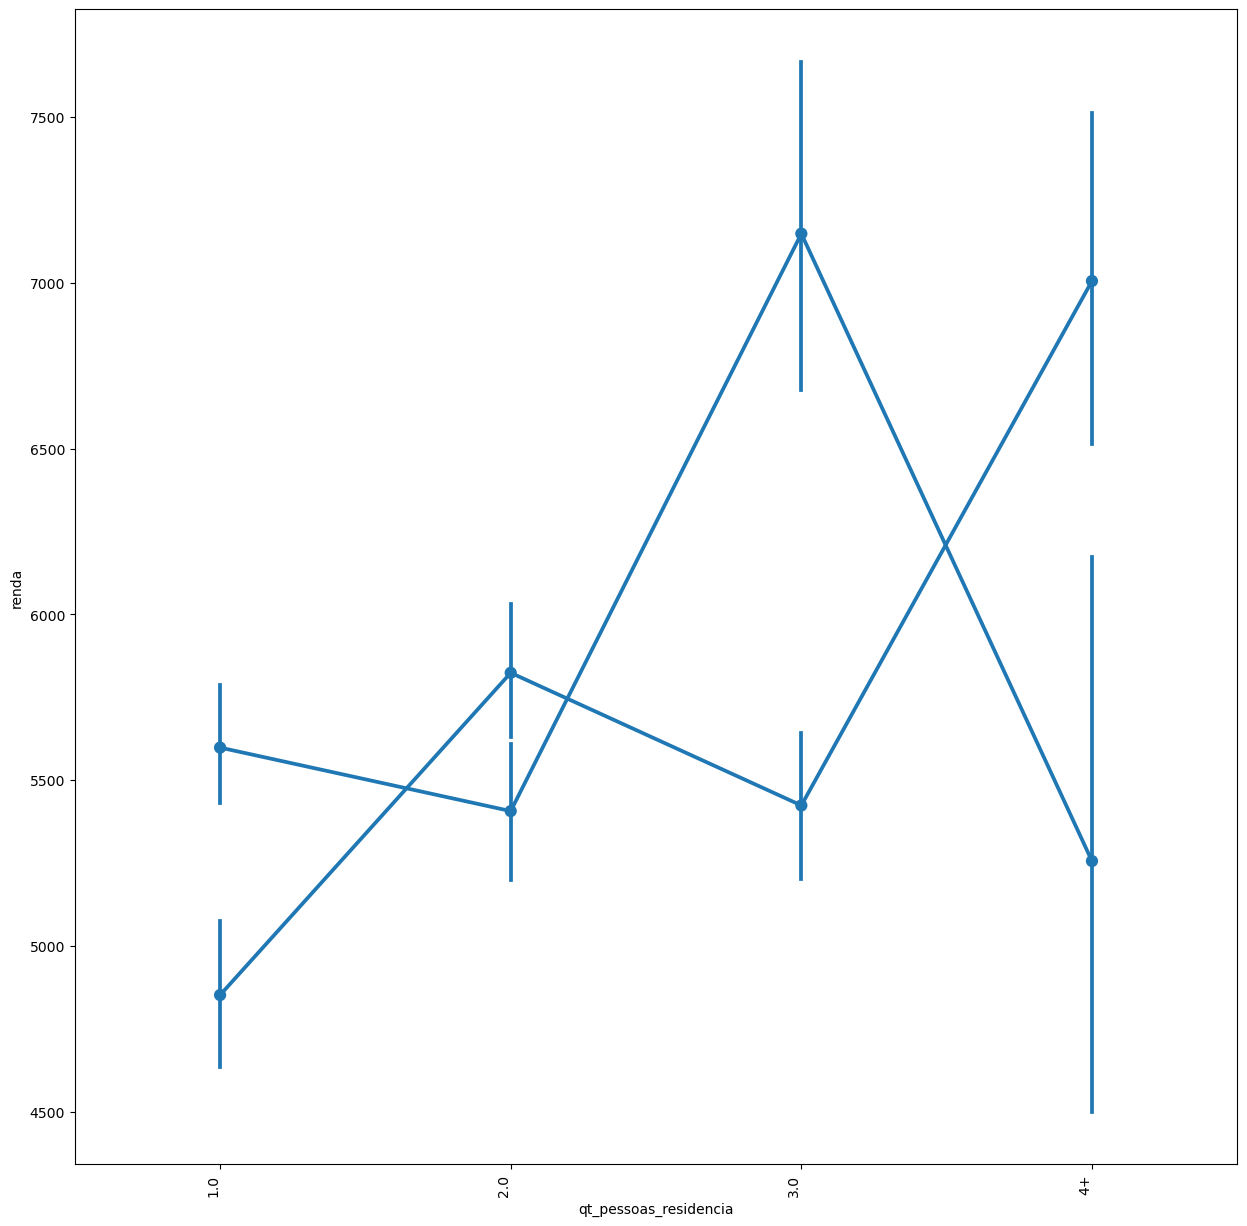

In [439]:
plt.close('all')

plt.rc('figure', figsize=(15, 15))

qtd_filhos = sns.pointplot(y = 'renda', x = 'qtd_filhos', data = df2)
qt_pessoas_residencia = sns.pointplot(y = 'renda', x = 'qt_pessoas_residencia', data = df2)

qtd_filhos.set_xticklabels(qtd_filhos.get_xticklabels(), rotation=90, horizontalalignment='right')
qt_pessoas_residencia.set_xticklabels(qt_pessoas_residencia.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.subplots_adjust(wspace=0.15, hspace=0.5)